# Sentiment Driven Stock Predictions

## ToDo
* @Nathan add comments
* @Bryan/ Kevin explore more data preprocessing techniques
* Remove twitter stuff
* Pick a sentiment analysis algo - currently randomforrest is working best
* Explore more prediction algorithms
  * Use non-binary classifiers to directly predict time series results instead of a binary algorithm
  * Implement better trading simulation algorithm based on above

---

* Need more news data for more testing
* Add more technical indicators for stock stuff
* Test on more stocks like SPY etc
* Add some analysis of returns

## Importing Data

In [ ]:
# First, mount your drive (might happen automatically)
from google.colab import drive
drive.mount('/content/drive')

!nvidia-smi

Mounted at /content/drive
Fri Mar 12 01:31:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                              

### First time downloading data to drive

In [ ]:
## First time import to transfer data from kaggle to Google Drive

## alternatively just download a dataset and upload it to your google drive

## Generate an API key using the instructions on this site - https://medium.com/analytics-vidhya/how-to-directly-download-kaggle-dataset-to-google-drive-aa06175712e2
## Next, on the files tab on the left browse to content and transfer the downloaded files from /content to "MyDrive"

# import os

# os.environ['KAGGLE_USERNAME'] = "your username"
# os.environ['KAGGLE_KEY'] = "your api key"

# !kaggle datasets download -d aaron7sun/stocknews

 98% 273M/278M [00:02<00:00, 76.6MB/s]
100% 278M/278M [00:02<00:00, 105MB/s] 


### Normal data import

In [ ]:
# Once data has already been transferred, use this to import data from your drive

!cp '/content/drive/MyDrive/ECE 579 Project/stooq_all_us_daily_data.zip' .
!cp '/content/drive/MyDrive/ECE 579 Project/stocknews.zip' .
!cp '/content/drive/MyDrive/ECE 579 Project/tweets-about-the-top-companies-from-2015-to-2020.zip' .

# make folder structure
!mkdir stock_data
!mkdir stock_news
!mkdir tweets

# unzip files
!unzip -q stooq_all_us_daily_data.zip -d stock_data
!unzip -q tweets-about-the-top-companies-from-2015-to-2020 -d tweets
!unzip -q stocknews.zip -d stock_news

!ls

drive	     stocknews.zip
sample_data  stooq_all_us_daily_data.zip
stock_data   tweets
stock_news   tweets-about-the-top-companies-from-2015-to-2020.zip


### Stock data class

In [ ]:
# class for stock data
import os
import pandas as pd
from datetime import datetime, date
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt 
%matplotlib inline

class Stock_data():
  
  def __init__(self, symbol, historical = True, timeframe = 'daily', source_folder = '/content/stock_data/data/daily/us'):
    self.symbol = symbol + '.us.txt'
    self.historical = historical
    self.timeframe = timeframe
    self.source_folder = source_folder
    self.data = pd.DataFrame()

    # get csv path from symbol by searching
    for root, dirs, files in os.walk(self.source_folder):
      if self.symbol in files:
        self.csv_path = os.path.join(root, self.symbol)

    if not self.csv_path:
      print('Error, symbol not found')
  
    # import data
    if historical == True & bool(timeframe == 'daily'):
      self.import_data()

  # function for importing data
  def import_data(self):
    self.data = pd.read_csv(self.csv_path, index_col = '<DATE>', parse_dates=['<DATE>'],
                            date_parser=lambda x: datetime.strptime(x, '%Y%m%d'))

  # removes excess columns
  def clean_data(self):
    del self.data['<TICKER>']
    del self.data['<PER>']
    del self.data['<OPENINT>']
    del self.data['<TIME>']

  # gets data from a range of dates
  def get_daterange(self, start_date, end_date, data = 0):
    if data:
      temp_data = data
    else:
      temp_data = data

    temp_data = temp_data.loc[(temp_data['<DATE>'] <= end_date) & (temp_data['<DATE>'] >= start_date)]
    temp_data = temp_data.reset_index()
    return temp_data

  # returns input data with a binary label depending on if the stock price went up or down that day
  def get_binarylabel(self, data):
    if data:
      temp_data = data
    else:
      temp_data = data

    temp_data.loc[temp_data['<CLOSE>'] - temp_data['<OPEN>'] > 0, 'Label'] = int(1)
    temp_data.loc[temp_data['<CLOSE>'] - temp_data['<OPEN>'] <= 0, 'Label'] = int(0)
    return temp_data

  def get_laggedbinarylabel(self, lag=1, data = 0):
    if data:
      temp_data = data
    else:
      temp_data = data

    temp_data.loc[temp_data['<CLOSE>'] - temp_data['<OPEN>'] > 0, 'Label'] = int(1)
    temp_data.loc[temp_data['<CLOSE>'] - temp_data['<OPEN>'] <= 0, 'Label'] = int(0)
    return temp_data

  def get_renamed(self):
    return self.data.rename(columns = {'<DATE>':'Date', '<OPEN>':'Open', '<HIGH>':'High', '<LOW>':'Low', '<CLOSE>':'Close', '<VOL>':'Vol'}, inplace = True) 

  def set_data(self, dataframe):
    self.data = dataframe

  def get_data(self):
    return self.data


# function to report performance metrics
def report(labels, predictions):

  # Report accuracy on test data
  matrix = confusion_matrix(labels, predictions)
  print('Confusion Matrix')
  print(matrix)
  print()
  score = accuracy_score(labels, predictions)
  print('Overall prediction accuracy: ' + str(score) + '\n')
  report = classification_report(labels, predictions)
  print('Classification Report: ')
  print(report)


In [ ]:
# import stock data by setting up data class
# imports djia data (dia etf)
dia_data = Stock_data('dia')
# uses clean function of data class to remove excess columns
dia_data.clean_data()

# same for s&p 500 (spy etc) dataset
spy_data = Stock_data('spy')
spy_data.clean_data()

# make sure data looks right
print(dia_data.data)

              <OPEN>    <HIGH>    <LOW>  <CLOSE>     <VOL>
<DATE>                                                    
2005-02-25   87.6640   88.4780   87.571   88.428   6101982
2005-02-28   88.2250   88.9380   87.535   87.891   9135557
2005-03-01   87.9500   88.5290   87.950   88.324   6510615
2005-03-02   87.9850   88.7010   87.932   88.192   9343052
2005-03-03   88.4780   88.6830   87.836   88.341  10124004
...              ...       ...      ...      ...       ...
2021-02-01  302.2800  303.3500  300.140  302.020   3138644
2021-02-02  304.5399  308.4300  304.520  306.820   3090522
2021-02-03  306.1000  307.9353  305.180  307.260   2087820
2021-02-04  307.8500  310.6700  307.770  310.670   2638783
2021-02-05  312.3600  312.5500  310.870  311.540   1955091

[4014 rows x 5 columns]


### Data Visualization - Tweets

#### Sweetviz visualization

In [ ]:
!pip install sweetviz

                                             |          | [  0%]   00:00 -> (? left)


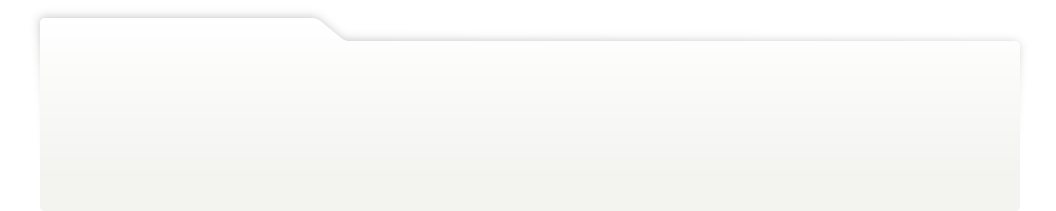
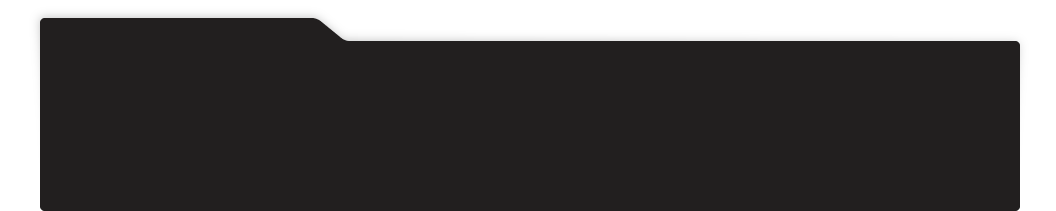
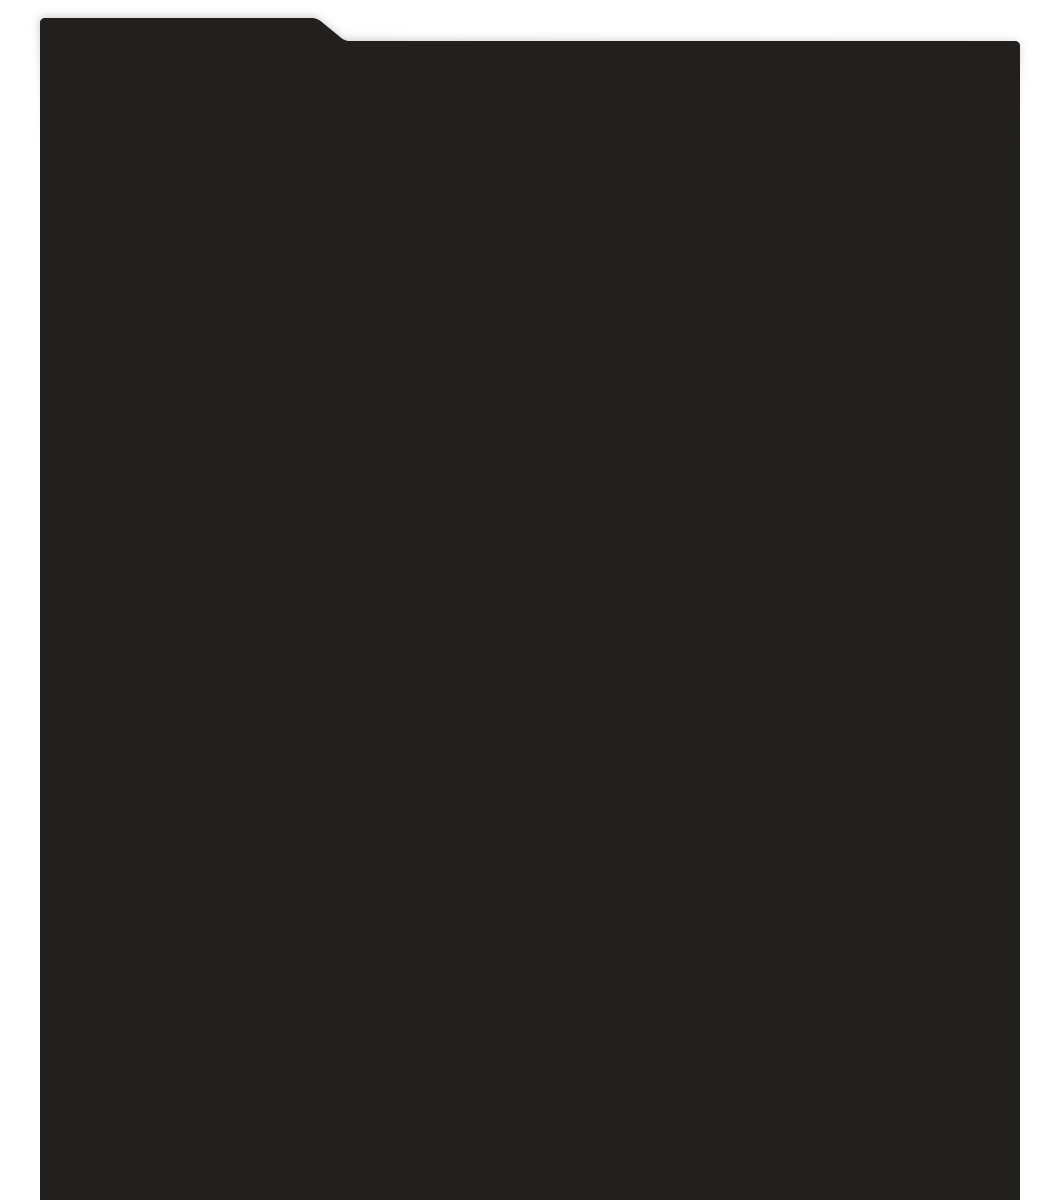
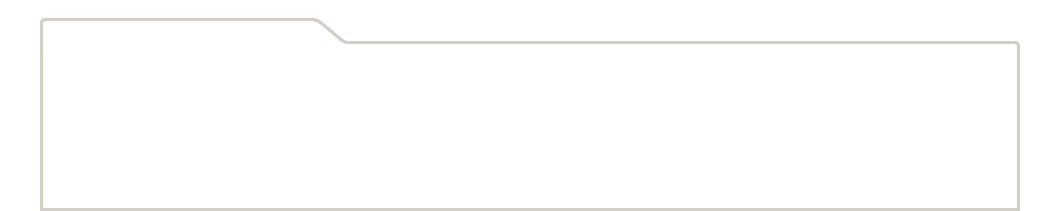
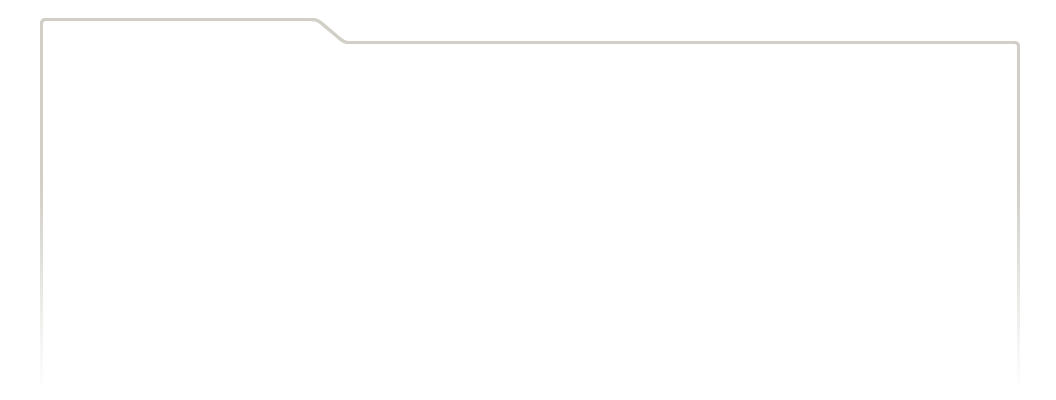
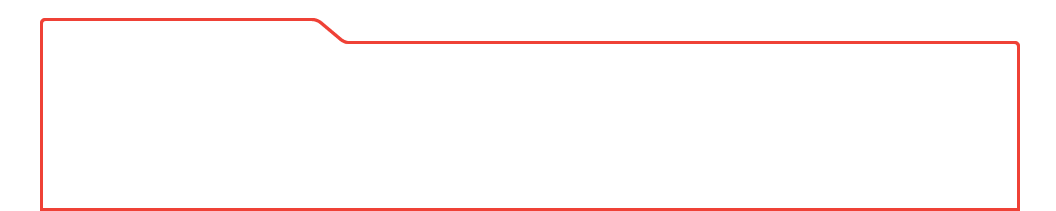
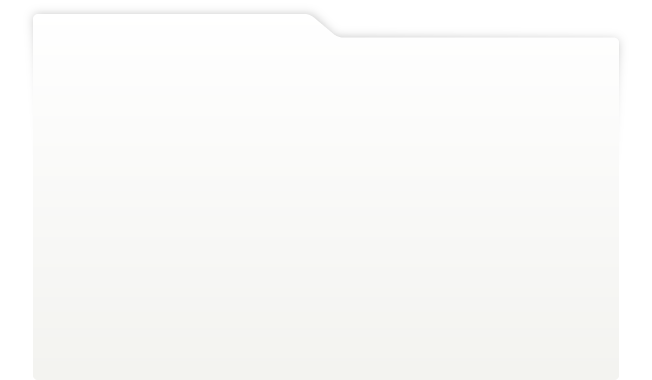
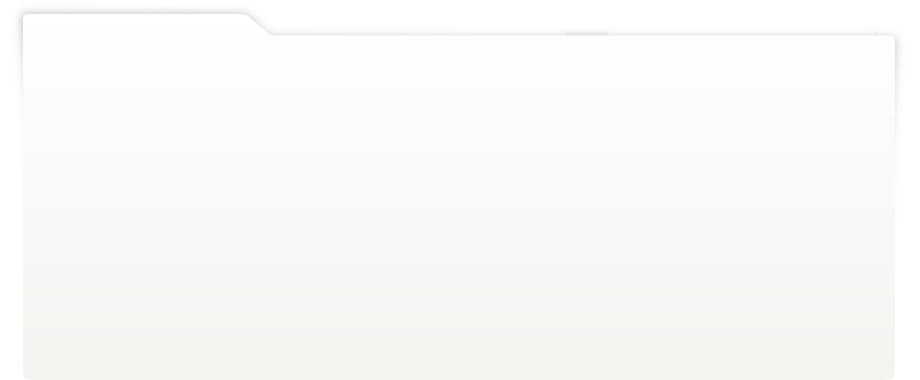
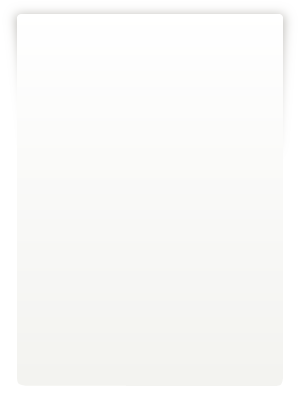
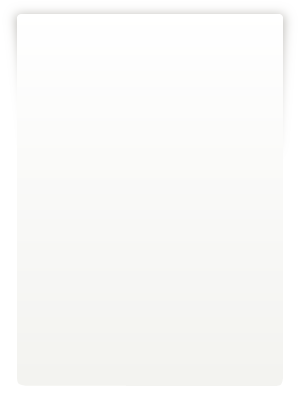
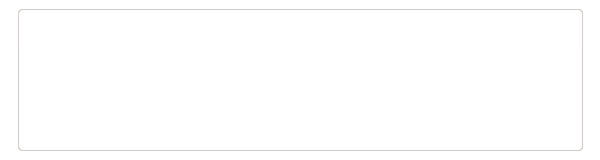
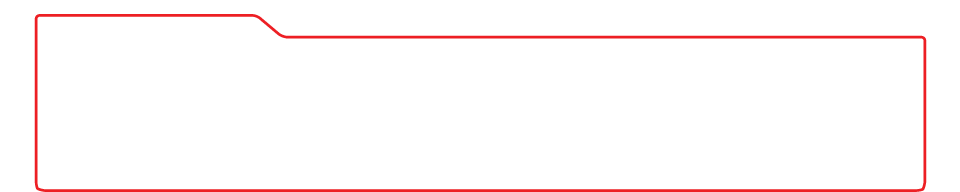
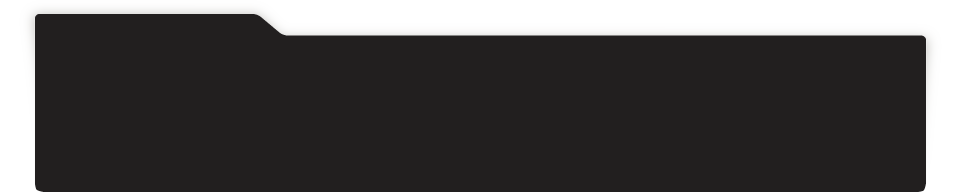
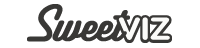
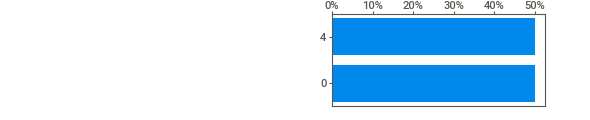
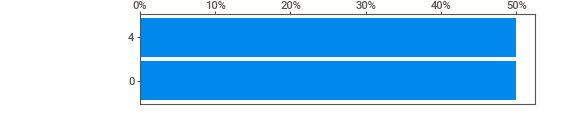
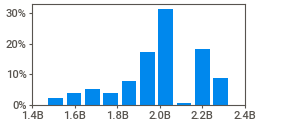
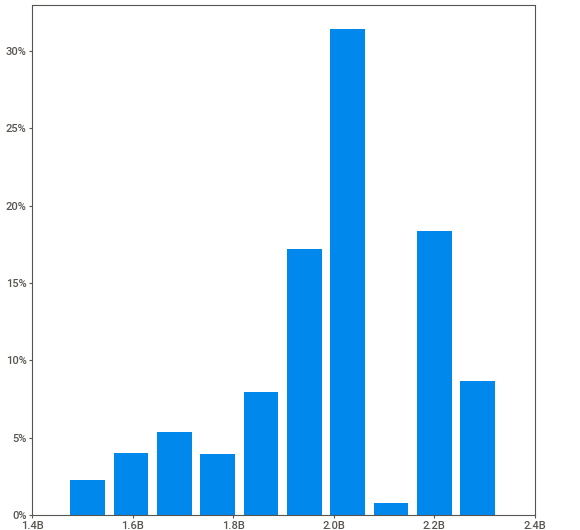
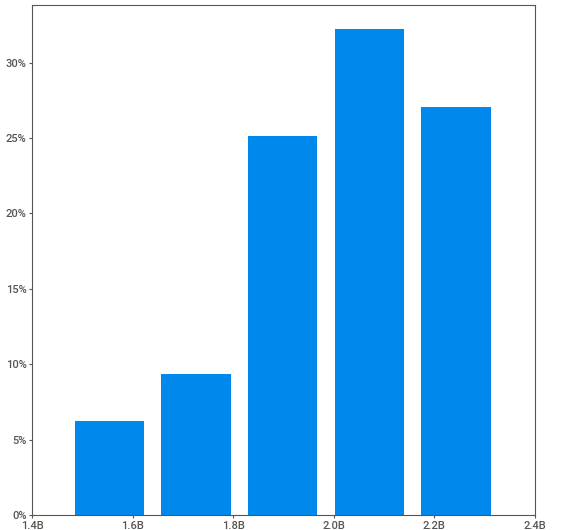
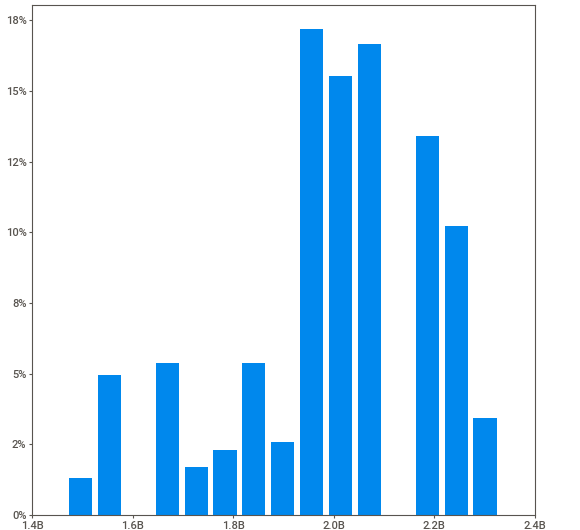
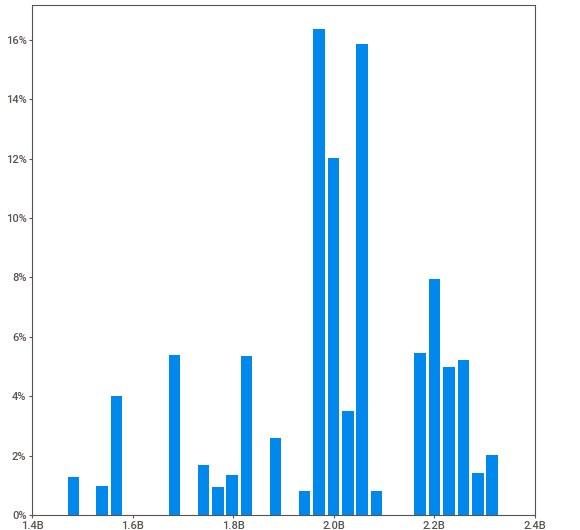
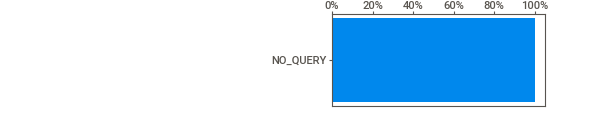
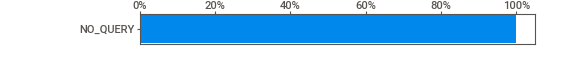
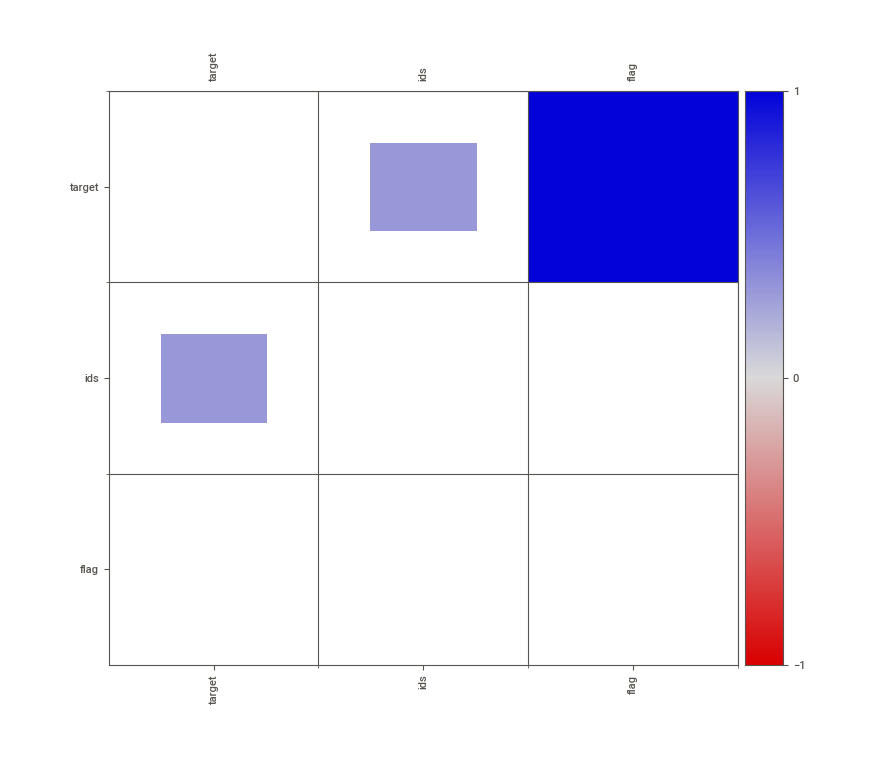
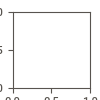

In [ ]:
import sweetviz as sv

twitter_report = sv.analyze(twitter_data)
twitter_report.show_notebook()

## Sentiment Analysis

In [ ]:
# Displaying news headlines dataset

df = pd.read_csv('stock_news/Combined_News_DJIA.csv')
df

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who k

### News

#### Random Forrest/ Bag of Words

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

class RandomForrestSentiment():

  def __init__(self, stock_dataset, news_dataset_path = 'stock_news/Combined_News_DJIA.csv'):
    self.news_path = news_dataset_path
    self.stock_data = stock_dataset
    self.news_data = pd.read_csv(news_dataset_path)

  # sets up news dataset for random forrest
  def prepare_news_data(self, data = 0, label = 'source'):
    if label != 'source':
    # allows using next day's stock change by providing stock dataframe, can make this better
      if data:
        self.news_data['Label']  = data['Label'].astype(int)

    # split data
    self.train = self.news_data[self.news_data['Date'] < '20150101']
    self.test = self.news_data[self.news_data['Date'] > '20141231']

    # remove extra indices
    self.data = self.train.iloc[:, 2:27]

    # remove non alphabetical characters
    self.data.replace("[^a-zA-Z]", " ", regex=True, inplace=True)

    # rename columns
    list1 = [i for i in range(25)]
    new_Index = [str(i) for i in list1]
    self.data.columns = new_Index

    # make everything lowercase
    for index in new_Index:
        self.data[index] = self.data[index].str.lower()

    # create list for each row merging all headlines into one
    self.headlines = []
    for row in range(0, len(self.data.index)):
        self.headlines.append(' '.join(str(x) for x in self.data.iloc[row, 0:25]))

  def tokenize_data(self, bag = True, ngrams = 2):
    # convert all sentences into vectors
    self.countVector = CountVectorizer(ngram_range=(ngrams, ngrams))
    #ngram(2,2) means it will combine the 2 words together and assign the value

    # bag of words
    if bag:
      self.trainDataset = self.countVector.fit_transform(self.headlines)

  def train_model(self):
    # Setup random forest classifier and train
    self.randomClassifier = RandomForestClassifier(n_estimators=200, criterion='entropy')
    self.randomClassifier.fit(self.trainDataset, self.train['Label'])

  def test_model(self):
    # predict for test data
    self.testTransform =[]
    for row in range(0, len(self.test.index)):
        self.testTransform.append(' '.join(str(x) for x in self.test.iloc[row, 2:27]))
        
    self.test_dataset = self.countVector.transform(self.testTransform)
    self.predictions = self.randomClassifier.predict(self.test_dataset)

  def get_performance_report(self):
    report(self.test['Label'], self.predictions)


In [ ]:
len(generic_forrest.headlines)

1863

In [ ]:
generic_forrest = RandomForrestSentiment(spy_data)
generic_forrest.prepare_news_data()
generic_forrest.tokenize_data()
generic_forrest.train_model()
generic_forrest.test_model()
generic_forrest.get_performance_report()

Confusion Matrix
[[131  55]
 [  2 190]]

Overall prediction accuracy: 0.8492063492063492

Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.70      0.82       186
           1       0.78      0.99      0.87       192

    accuracy                           0.85       378
   macro avg       0.88      0.85      0.85       378
weighted avg       0.88      0.85      0.85       378



In [ ]:
# Prep all data for headlines
# remove extra indices

data = df.iloc[:, 2:27]

# remove non alphabetical characters
data.replace("[^a-zA-Z]", " ", regex=True, inplace=True)

# rename columns
list1 = [i for i in range(25)]
new_Index = [str(i) for i in list1]
data.columns = new_Index

# make everything lowercase
for index in new_Index:
    data[index] = data[index].str.lower()

# create list for each row merging all headlines into one
news_headlines = []
for row in range(0, len(data.index)):
    news_headlines.append(' '.join(str(x) for x in data.iloc[row, 0:25]))

### Twitter

In [ ]:
twitter_comp = pd.read_csv('/content/tweets/Tweet.csv', parse_dates=['post_date'])
twitter_comp

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0.0,0.0,1.0
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0.0,0.0,0.0
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0.0,0.0,0.0
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0.0,0.0,1.0
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0.0,0.0,1.0
...,...,...,...,...,...,...,...
1352407,779002347645263872,AppleStockPrice,1474563607,Apple Stock Price: 114.58 #apple $AAPL,0.0,0.0,0.0
1352408,779002349318705155,Alexability,1474563607,Top sentiment for SP1500 stocks at midday: $AD...,0.0,0.0,0.0
1352409,779002394516525056,alexandriatech,1474563618,Top #sentiment for #SP1500 #stocks at midday: ...,0.0,0.0,0.0
1352410,779002453454794753,_peripherals,1474563632,Samsung and #Apple Could Soon Be Neighbors. Re...,0.0,0.0,0.0


In [ ]:
twitter_comp = pd.read_csv('/content/tweets/Company.csv')
twitter_comp

,ticker_symbol,company_name
0,AAPL,apple
1,GOOG,Google Inc
2,GOOGL,Google Inc
3,AMZN,Amazon.com
4,TSLA,Tesla Inc
5,MSFT,Microsoft


In [ ]:
twitter_comp = pd.read_csv('/content/tweets/Company_Tweet.csv')
twitter_comp

,tweet_id,ticker_symbol
0,550803612197457920,AAPL
1,550803610825928706,AAPL
2,550803225113157632,AAPL
3,550802957370159104,AAPL
4,550802855129382912,AAPL
...,...,...
4336440,1212158772015034369,TSLA
4336441,1212159099632267268,TSLA
4336442,1212159184931717120,TSLA
4336443,1212159838882533376,TSLA


In [ ]:
twitter_data = pd.read_csv('/content/tweets/training.1600000.processed.noemoticon.csv', encoding = 'ISO-8859-1' , names = ["target", "ids", "date", "flag", "user", "text"], parse_dates=['date'])
del twitter_data['ids']
del twitter_data['flag']
del twitter_data['user']
twitter_data

/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


,target,date,text
0,0,2009-04-06 22:19:45,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,2009-04-06 22:19:49,is upset that he can't update his Facebook by ...
2,0,2009-04-06 22:19:53,@Kenichan I dived many times for the ball. Man...
3,0,2009-04-06 22:19:57,my whole body feels itchy and like its on fire
4,0,2009-04-06 22:19:57,"@nationwideclass no, it's not behaving at all...."
...,...,...,...
1599995,4,2009-06-16 08:40:49,Just woke up. Having no school is the best fee...
1599996,4,2009-06-16 08:40:49,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2009-06-16 08:40:49,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2009-06-16 08:40:49,Happy 38th Birthday to my boo of alll time!!! ...


In [ ]:
# convert 4 to 1
twitter_data.loc[twitter_data['target'] == 4, 'target'] = int(1)

# group by dates
date_grouped = twitter_data.groupby(twitter_data['date'].dt.date).agg(lambda x: ''.join(set(x)))
# date_grouped['text'][1]
data_grouped

"BACK FRM STUDIO!!! HAD SO MUCH FUNNN  WOO HOO@saritaonline and snoring zzzZzzz.. &quot;It's a big ass table. Take that Apple&quot; http://jdem.cz/a9367 Spring time is over  http://twitpic.com/2yaghWow.(non work related) I've been doing the SEO for a site I designed and it's now ranking 1-5 on MSN, Google and ASK - Sadly, not Yahoo i kept myself awake by asking some tantalizing questions  the corporate presenter loves me @MichaelCalienes sure it is..... ;-) No, actually a hand grenade.  @nick_foster Right now, actually a Twitter app for automating a lot of stuff. I'm currently using it on this account to test it @MmmBaileys Me  Happy Birthday! Loving the foxy avatar pic as well  Serious party plans for the big day?good day to all @sylver im finally awake but idnt feel soo good actually it is not really a secret link @Mushroomchannel Thank you- the vegan pizza was fabulous! I am now obsessed with your website.  Can't get enough.oh wtf @ house. NOT COOL. *looking at the clock* Good God T

In [ ]:
date_grouped

,text
date,
2009-04-06,@camillejaiden I saw that there's a new kind o...
2009-04-07,BACK FRM STUDIO!!! HAD SO MUCH FUNNN WOO HOO@...
2009-04-17,http://twitpic.com/3i8rw - It came! @DJ_Reeves...
2009-04-18,is at Fairview with @spicyspice &amp; @wickerc...
2009-04-19,@circe_21 but for now youll just have to hang ...
2009-04-20,"@jennEjones I went to Google on my BB, searche..."
2009-04-21,@caramelflavored UHHHHHHH. pause. http://mcfly...
2009-05-01,Playright @CarnivalOfSquid I really like this ...
2009-05-02,cannot decide what to today since he has work ...


### DistilBERT

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.9MB 18.8MB/s 
     |████████████████████████████████| 890kB 49.9MB/s 
     |████████████████████████████████| 3.2MB 44.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=5464ea22688acf34a5fde3a97df4fd08b477fb31bdef68e996370667058ce4d6
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertModel
import logging
logging.basicConfig(level=logging.ERROR)

In [ ]:
# # Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 5
LEARNING_RATE = 1e-05

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)
# tokenizer = Tokenizer.from_pretrained('distilgpt2', truncation=True, do_lower_case=True)

In [ ]:
class LabelDataset(Dataset):

  def __init__(self, dataframe, tokenizer, max_len):
    self.tokenizer = tokenizer
    self.data = dataframe
    self.text = dataframe.Headlines
    self.targets = self.data.Labels
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, index):
    text = str(self.text[index])
    text = " ".join(text.split())

    inputs = self.tokenizer.encode_plus(
      text,
      None,
      add_special_tokens=True,
      max_length=self.max_len,
      pad_to_max_length=True,
      return_token_type_ids=True
    )
    ids = inputs['input_ids']
    mask = inputs['attention_mask']
    token_type_ids = inputs["token_type_ids"]


    return {
      'ids': torch.tensor(ids, dtype=torch.long),
      'mask': torch.tensor(mask, dtype=torch.long),
      'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
      'targets': torch.tensor(self.targets[index], dtype=torch.float)
    }

In [ ]:
# Creating the dataset and dataloader for the neural network
train_dat = pd.DataFrame()
train_dat['Headlines'] = news_headlines
train_dat['Labels'] = df['Label']
# train_dat['Labels'] = stock_lagged['Label']
# train_dat['Labels'] = generic_forrest.news_data['Label']
train_dat['Labels'] = train_dat.iloc[:, 1:].values.tolist()
train_dat['Date'] = df['Date']
train_dat

new_df = train_dat

# train_size = 0.8
# train_data=new_df.sample(frac=train_size,random_state=200)
# test_data=new_df.drop(train_data.index).reset_index(drop=True)
# train_data = train_data.reset_index(drop=True)

# Split data
train_data = new_df[new_df['Date'] < '2014-10-01']
test_data = new_df[new_df['Date'] >= '2014-10-01']
# test_data = new_df.loc[(new_df['Date'] >= '2014-10-01') & (new_df['Date'] <= '2015-07-01')]
# val_data = new_df[new_df['Date'] > '2015-07-01']

del train_data['Date']
del test_data['Date']
# del val_data['Date']

test_data = test_data.reset_index()
# val_data = val_data.reset_index()

print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))
# print("VAL Dataset: {}".format(val_data.shape))

training_set = LabelDataset(train_data, tokenizer, MAX_LEN)
testing_set = LabelDataset(test_data, tokenizer, MAX_LEN)
# validation_set = LabelDataset(val_data, tokenizer, MAX_LEN)

FULL Dataset: (1989, 3)
TRAIN Dataset: (1547, 2)
TEST Dataset: (442, 3)


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

val_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)
# validation_loader = DataLoader(validation_set, ** val_params)

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 
# Example source: https://colab.research.google.com/github/DhavalTaunk08/Transformers_scripts/blob/master/Transformers_multilabel_distilbert.ipynb#scrollTo=FeftvDhjDSPp

class DistilBERTClass(torch.nn.Module):
  def __init__(self):
    super(DistilBERTClass, self).__init__()
    # self.l1 = DistilBertModel.from_pretrained("distilgpt2")
    self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
    self.pre_classifier = torch.nn.Linear(768, 768)
    self.dropout = torch.nn.Dropout(0.1)
    self.classifier = torch.nn.Linear(768, 1)

  def forward(self, input_ids, attention_mask, token_type_ids):
    output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
    hidden_state = output_1[0]
    pooler = hidden_state[:, 0]
    pooler = self.pre_classifier(pooler)
    pooler = torch.nn.Tanh()(pooler)
    pooler = self.dropout(pooler)
    output = self.classifier(pooler)
    return output

model = DistilBERTClass()
model.to(device)

DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_featu

In [ ]:
def loss_fn(outputs, targets):
  return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

def train_model(epoch):
  model.train()
  for _,data in tqdm(enumerate(training_loader, 0)):
    ids = data['ids'].to(device, dtype = torch.long)
    mask = data['mask'].to(device, dtype = torch.long)
    token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
    targets = data['targets'].to(device, dtype = torch.float)

    outputs = model(ids, mask, token_type_ids)

    optimizer.zero_grad()
    loss = loss_fn(outputs, targets)
    if _%5000==0:
      print(f'Epoch: {epoch}, Loss:  {loss.item()}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
for epoch in range(EPOCHS):
    train_model(epoch)

1it [00:00,  3.38it/s]

Epoch: 0, Loss:  0.6995131373405457


387it [01:33,  4.12it/s]
1it [00:00,  4.38it/s]

Epoch: 1, Loss:  0.7472215294837952


387it [01:34,  4.09it/s]
1it [00:00,  4.29it/s]

Epoch: 2, Loss:  0.752421498298645


387it [01:34,  4.09it/s]
1it [00:00,  4.34it/s]

Epoch: 3, Loss:  0.35861483216285706


387it [01:35,  4.07it/s]
1it [00:00,  4.30it/s]

Epoch: 4, Loss:  0.04436396434903145


387it [01:35,  4.07it/s]


In [ ]:
def validation(testing_loader):
  model.eval()
  fin_targets=[]
  fin_outputs=[]
  with torch.no_grad():
    for _, data in tqdm(enumerate(testing_loader, 0)):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.float)
      outputs = model(ids, mask, token_type_ids)
      fin_targets.extend(targets.cpu().detach().numpy().tolist())
      fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
  return fin_outputs, fin_targets

In [ ]:
outputs, targets = validation(testing_loader)

# val_out, val_targets = validation(validation_loader)
# val_outputs = np.array(val_out) >= 0.5

final_outputs = np.array(outputs) >=0.5

111it [00:10, 10.60it/s]


In [ ]:
# Saving the files to drive

output_model_file = "/content/drive/MyDrive/ECE 579 Project/models/distilbert_model_newslabels.bin"
output_vocab_file = "/content/drive/MyDrive/ECE 579 Project/models/vocab_newslabels.bin"

torch.save(model, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('Saved')

Saved


In [ ]:
report(targets, final_outputs.astype(int))

Confusion Matrix
[[ 68 146]
 [ 79 149]]

Overall prediction accuracy: 0.49095022624434387

Classification Report: 
              precision    recall  f1-score   support

         0.0       0.46      0.32      0.38       214
         1.0       0.51      0.65      0.57       228

    accuracy                           0.49       442
   macro avg       0.48      0.49      0.47       442
weighted avg       0.48      0.49      0.48       442



In [ ]:
# report(val_targets, val_outputs.astype(int))

### Vadersentiment

In [ ]:
!pip install vaderSentiment

     |████████████████████████████████| 133kB 19.1MB/s 


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

vader_analyzer = SentimentIntensityAnalyzer()
out = []

# use headlines list from generic_forrest
for item in range(0, len(news_headlines)):
  out.append(vader_analyzer.polarity_scores(news_headlines[item]))

# out.pop(0)
vader_output = pd.DataFrame(out, columns=['neg', 'neu', 'pos', 'compound'])

## XGBoost Stuff

In [ ]:
# Building input data - including stock data, sentiment, technical indicators (RSI/ MA/ etc.)
# stock data
start_date = '2008-08-08'
end_date = '2016-06-28'
test_stock_data = dia_data.data
test_stock_data = stock_data.loc[(stock_data['<DATE>'] >= start_date) & (stock_data['<DATE>'] <= end_date)]
test_stock_data = test_stock_data.reset_index()

# technical indicators
# moving average columns
test_stock_data['MA5'] = test_stock_data['<CLOSE>'].rolling(window=5).mean()
test_stock_data['MA10'] = test_stock_data['<CLOSE>'].rolling(window=10).mean()
test_stock_data['MA20'] = test_stock_data['<CLOSE>'].rolling(window=20).mean()
test_stock_data['MA50'] = test_stock_data['<CLOSE>'].rolling(window=50).mean()
test_stock_data['MA200'] = test_stock_data['<CLOSE>'].rolling(window=200).mean()

# Force Index (ForceIndex)
test_stock_data['FI'] = test_stock_data['<CLOSE>'].diff(1) * test_stock_data['<VOL>']

# final concat of data inputs    
xgboost_data = pd.concat([vader_output, test_stock_data], axis=1, join='inner')
# rename columns since xgboost doesn't like <>
xgboost_data.rename(columns = {'<DATE>':'Date', '<OPEN>':'Open', '<HIGH>':'High', '<LOW>':'Low', '<CLOSE>':'Close', '<VOL>':'Vol'}, inplace = True)
# get rid of old index
del xgboost_data['index']

# make sure data looks good
xgboost_data

,neg,neu,pos,compound,Date,Open,High,Low,Close,Vol,MA5,MA10,MA20,MA50,MA200,FI
0,0.221,0.741,0.039,-0.9982,2008-08-08,93.219,96.008,93.057,95.446,38254036,NaN,NaN,NaN,NaN,NaN,NaN
1,0.172,0.746,0.082,-0.9837,2008-08-11,95.483,96.908,95.307,96.136,27554381,NaN,NaN,NaN,NaN,NaN,1.901252e+07
2,0.116,0.832,0.052,-0.9679,2008-08-12,95.841,95.901,94.717,95.121,27502355,NaN,NaN,NaN,NaN,NaN,-2.791489e+07
3,0.139,0.800,0.061,-0.9818,2008-08-13,94.717,94.813,93.608,94.189,34546335,NaN,NaN,NaN,NaN,NaN,-3.219718e+07
4,0.175,0.728,0.097,-0.9850,2008-08-14,93.738,95.744,93.608,94.992,30158885,95.1768,NaN,NaN,NaN,NaN,2.421758e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1980,0.196,0.751,0.053,-0.9979,2016-06-22,164.530,165.170,163.780,163.920,3205796,163.7500,163.801,164.1290,163.6164,157.13315,-1.442608e+06
1981,0.112,0.815,0.072,-0.9833,2016-06-23,165.220,165.970,164.920,165.970,3167600,164.2500,163.828,164.2155,163.6532,157.21755,6.493580e+06
1982,0.160,0.754,0.087,-0.9897,2016-06-24,161.120,163.080,159.970,160.270,12324106,163.7320,163.391,164.0260,163.5724,157.28425,-7.024740e+07
1983,0.096,0.855,0.049,-0.9167,2016-06-27,159.180,159.180,157.260,158.010,8327343,162.5080,162.852,163.7045,163.4520,157.33560,-1.881980e+07


In [ ]:
# split into test and train around 2014-10-01
X_train = xgboost_data[xgboost_data['Date'] < '2014-10-01']
del X_train['Date']
X_test = xgboost_data[xgboost_data['Date'] >= '2014-10-01']
del X_test['Date']
y_train = df[df['Date'] < '2014-09-30']['Label']
y_test = df[df['Date'] >= '2014-09-30']['Label']

# remove some extra data pieces.... (not sure why these are here)
y_test.pop(1985)
y_test.pop(1986)
y_test.pop(1987)
y_test.pop(1988)

1

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# setup xgboost classifier (binary classifier)
model = XGBClassifier(max_depth = 50, n_estimators = 500, learning_rate = 0.01)
# train model
model.fit(X_train, y_train)
# predict test data
y_pred = model.predict(X_test)
# display accuracy
accu_score = accuracy_score(y_test, y_pred)
print(accu_score)
print(classification_report(y_pred, y_test))

0.55125284738041
              precision    recall  f1-score   support

           0       0.45      0.55      0.49       174
           1       0.65      0.55      0.60       265

    accuracy                           0.55       439
   macro avg       0.55      0.55      0.55       439
weighted avg       0.57      0.55      0.56       439



[Text(0, 0.5, 'Importance'), Text(0.5, 0, 'Columns')]

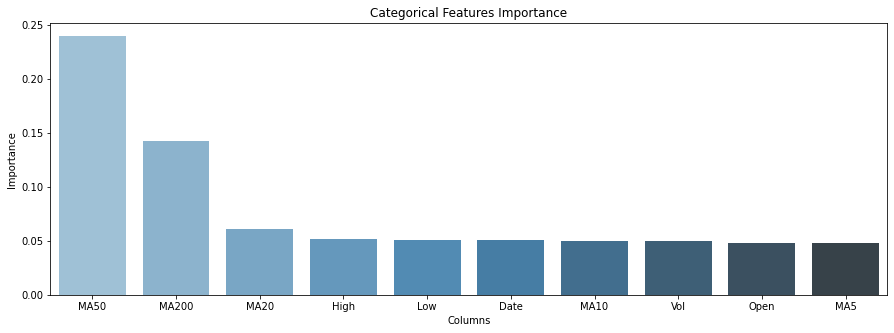

In [ ]:
import seaborn as sns

# plot feature importance in classifier
indices = np.argsort(model.feature_importances_)[::-1]

features = []
for i in range(10):
    features.append(xgboost_data.columns[indices[i]])

fig, ax = plt.subplots(figsize=(15,5))     

sns.barplot(x=features, y=model.feature_importances_[indices[range(10)]],\
label="Importtant Categorical Features", palette=("Blues_d"),ax=ax).\
set_title('Categorical Features Importance')

ax.set(xlabel="Columns", ylabel = "Importance")

## Stock Backtesting Stuff

Could also use NewsAPI to pull the days news/ Twitters API containing a certain ticker + TD's API for pulling stock quotes/ other API for a final implementation

### Simple vectorized estimates

* Long model buys when sentiment is positive, sells when not
* Long short model buys when sentiment is positive and shorts when it is negative 

In [ ]:
#class Backtesting():
#   def __init__(self, stock_data, label_data, initial_value):
#     self.stock = stock_data
#     self.label = label_data
#     self.output_df = self.stock
#     self.init_val = initial_value
#     self.liquid = True
#     self.shares = 0
#     self.cur_val = self.init_val


In [ ]:
import numpy as np

# Vectorized simple solution in function form, class to follow after expansion including plotting etc.
def simple_backtest(start_date, predictions, stock_data, end_date = '2016-07-01'):
  test_stock_data = stock_data.loc[(stock_data['<DATE>'] >= start_date) & (stock_data['<DATE>'] <= end_date)]
  test_stock_data = stock_data[stock_data['<DATE>'] > start_date]
  test_stock_data = test_stock_data.reset_index()

  pred_df = pd.DataFrame(predictions, columns=['Sentiment'])
  pred_df['Open'] = test_stock_data['<OPEN>']
  pred_df['Close'] = test_stock_data['<CLOSE>']
  pred_df['Date'] = test_stock_data['<DATE>']
  # Shift percent change so that the next day's percent change is in line with the sentiment
  pred_df['Change'] = pred_df['Close'].pct_change().shift(-1).dropna()
  # Setup column for changes that our position will be exposed to (while we're bought in)
  pred_df['Pos_change'] = pred_df['Sentiment'] * pred_df['Change']
  # Setup column for long and short returns
  pred_df['Pos_change_shrt'] = pred_df['Change']*(-1) + pred_df['Pos_change']
  # Calculate cumulative return for dow jones, long positions, and long/short positions
  pred_df['Cumul_ret_dji'] = np.exp(np.log1p(pred_df['Change']).cumsum())
  pred_df['Cumul_ret_long'] = np.exp(np.log1p(pred_df['Pos_change']).cumsum())
  pred_df['Cumul_ret_long_shrt'] = (np.exp(np.log1p(pred_df['Pos_change']).cumsum()) + np.exp(np.log1p(pred_df['Pos_change_shrt']).cumsum()))/2
  return pred_df

In [ ]:
predictions = generic_forrest.predictions
stock_data = dia_data.data.reset_index()
# randomforrest
pred_df_forrest = simple_backtest('2014-12-31', predictions, stock_data)
# xgboost
pred_df_xgboost = simple_backtest('2014-12-31', y_pred, stock_data)
pred_df_xgboost

,Sentiment,Open,Close,Date,Change,Pos_change,Pos_change_shrt,Cumul_ret_dji,Cumul_ret_long,Cumul_ret_long_shrt
0,1,159.56,158.87,2015-01-02,-0.016869,-0.016869,0.000000,0.983131,0.983131,0.991565
1,1,158.12,156.19,2015-01-05,-0.008643,-0.008643,0.000000,0.974633,0.974633,0.987317
2,0,156.39,154.84,2015-01-06,0.012787,0.000000,-0.012787,0.987096,0.974633,0.980923
3,1,156.20,156.82,2015-01-07,0.018174,0.018174,0.000000,1.005036,0.992346,0.989779
4,0,158.30,159.67,2015-01-08,-0.008831,-0.000000,0.008831,0.996160,0.992346,0.994138
...,...,...,...,...,...,...,...,...,...,...
434,1,170.60,170.60,2016-09-22,-0.006858,-0.006858,0.000000,1.066469,1.116716,1.075004
435,1,170.37,169.43,2016-09-23,-0.009266,-0.009266,0.000000,1.056587,1.106368,1.069830
436,0,168.59,167.86,2016-09-26,0.007149,0.000000,-0.007149,1.064140,1.106368,1.066136
437,0,167.70,169.06,2016-09-27,0.006033,0.000000,-0.006033,1.070561,1.106368,1.063042


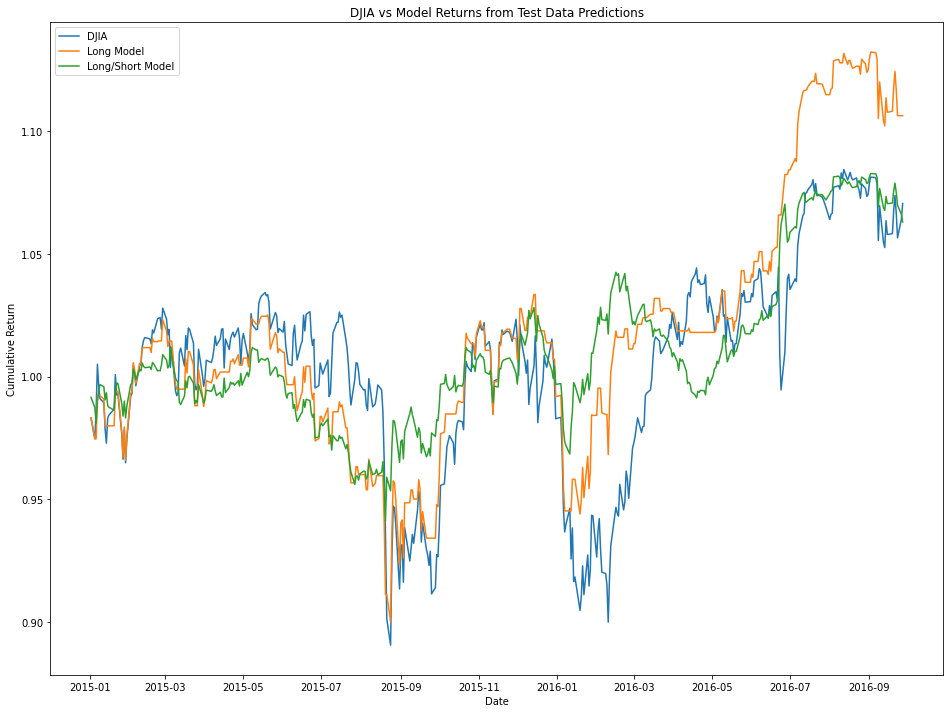

In [ ]:
# Plot results
import matplotlib.pyplot as plt
%matplotlib inline

def plot_backtest(prediction_df, title='DJIA vs Model Returns from Test Data Predictions', label_1='DJIA', label_2='Long Model', label_3='Long/Short Model'):
  pred_df = prediction_df

  plt.figure(figsize=(16, 12)) 
  plt.plot(pred_df['Date'], pred_df['Cumul_ret_dji'], label = label_1)
  plt.plot(pred_df['Date'], pred_df['Cumul_ret_long'], label = label_2)
  plt.plot(pred_df['Date'], pred_df['Cumul_ret_long_shrt'], label = label_3)
  plt.xlabel('Date')
  plt.title(title)
  plt.ylabel('Cumulative Return')
  plt.legend()
  plt.show()

plot_backtest(pred_df_xgboost)

In [ ]:
# Print stats for how good the model is including return, sharpe ratio, volatility, max drawdown

## RNN